# Quantum Process Tomography with Q# and Python #

## Abstract ##

In this sample, we will demonstrate interoperability between Q# and Python by using the QInfer and QuTiP libraries for Python to characterize and verify quantum processes implemented in Q#.
In particular, this sample will use *quantum process tomography* to learn about the behavior of a "noisy" Hadamard operation from the results of random Pauli measurements.

## Preamble ##

When working with Q# from languages other than C#, we normally need to separate Q# operations and functions into their own project.
We can then add the project containing our new operations as a *reference* to our interoperability project in order to run from within Visual Studio.
For running from Jupyter, though, we must manually add the other project to `sys.path` so that Python.NET can find the assemblies containing our new operations, as well as the assemblies from the rest of the Quantum Development Kit that get included as dependencies.

In [1]:
import qsharp 
from qsharp.tomography import single_qubit_process_tomography

In [2]:
import warnings; warnings.filterwarnings('ignore')

In [3]:
import sys
sys.path.append('./bin/Debug/netstandard2.0')

With the new assemblies added to `sys.path`, we can reference them using the Python.NET `clr` package.

In [4]:
import clr
clr.AddReference("Microsoft.Quantum.Canon")
clr.AddReference("PythonInterop")

Next, we import plotting support and the QuTiP library, since these will be helpful to us in manipulating the quantum objects returned by the quantum process tomography functionality that we call later.

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
import qutip as qt
qt.settings.colorblind_safe = True

## Setting up the Simulator ##

This sample is provided along with a small Python package to help facilitate interoperability.
We can import this package like any other Python package, provided that we have set `sys.path` correctly.

In particular, the `qsharp` package provides a `QuantumSimulator` class which wraps the `Microsoft.Quantum.Simulation.Simulators.QuantumSimulator` .NET class provided with the Quantum Development Kit.
This wrapper provides a few useful convenience features that we will use along the way.

In [7]:
qsim = qsharp.QuantumSimulator()
qsim

<QuantumSimulator(Microsoft.Quantum.Simulation.Simulators.QuantumSimulator) at 0x178e0986e80>

We can use our new simulator instance to run operations and functions defined in Q#.
To do so, we import the operation and function names as though the Q# namespaces were Python packages.

In [8]:
from Microsoft.Quantum.Samples.Python import (
    HelloWorld, NoisyHadamardChannel
)

Once we've imported the new names, we can then ask our simulator to run each function and operation using the `run` method.
Jupyter will denote messages emitted by the simulator with a blue sidebar to separate them from normal Python output.

In [9]:
hello_world = qsim.get(HelloWorld)
hello_world

Python type,qsharp.Callable
CLR type,Microsoft.Quantum.Samples.Python.HelloWorld
Assembly name,"PythonInterop, Version=1.0.0.0, Culture=neutral, PublicKeyToken=null"


In [10]:
qsim.run(hello_world, qsharp.Pauli.Z).Wait()

'Hello, world! PauliZ'

To obtain the output from a Q# operation or function, we must use the `result` function, since outputs are wrapped in .NET asynchronous tasks.
These tasks are wrapped in a future-like object for convenience.

In [11]:
noisy_h = qsim.run(NoisyHadamardChannel, 0.1).result()
noisy_h

<WrappedCLRObject(Microsoft.Quantum.Simulation.Core.PartialUnitary`2[[Microsoft.Quantum.Simulation.Core.Qubit, Microsoft.Quantum.Simulation.Core, Version=0.2.1806.3001, Culture=neutral, PublicKeyToken=40866b40fd95c7f5],[System.ValueTuple`2[[System.Double, mscorlib, Version=4.0.0.0, Culture=neutral, PublicKeyToken=b77a5c561934e089],[Microsoft.Quantum.Simulation.Core.Qubit, Microsoft.Quantum.Simulation.Core, Version=0.2.1806.3001, Culture=neutral, PublicKeyToken=40866b40fd95c7f5]], mscorlib, Version=4.0.0.0, Culture=neutral, PublicKeyToken=b77a5c561934e089]]) at 0x178e09d1160>

## Tomography ##

The `qsharp` interoperability package also comes with a `single_qubit_process_tomography` function which uses the QInfer library for Python to learn the channels corresponding to single-qubit Q# operations.
Here, we ask for 10,000 measurements from the noisy Hadamard operation that we defined above.

In [12]:
estimation_results = single_qubit_process_tomography(qsim, noisy_h, n_measurements=10000)

Preparing tomography model...
Performing tomography...


To visualize the results, it's helpful to compare to the actual channel, which we can find exactly in QuTiP.

In [13]:
depolarizing_channel = sum(map(qt.to_super, [qt.qeye(2), qt.sigmax(), qt.sigmay(), qt.sigmaz()])) / 4.0
actual_noisy_h = 0.1 * qt.to_choi(depolarizing_channel) + 0.9 * qt.to_choi(qt.hadamard_transform())

We then plot the estimated and actual channels as Hinton diagrams, showing how each acts on the Pauli operators $X$, $Y$ and $Z$.

(None, <matplotlib.axes._subplots.AxesSubplot at 0x178e367f198>)

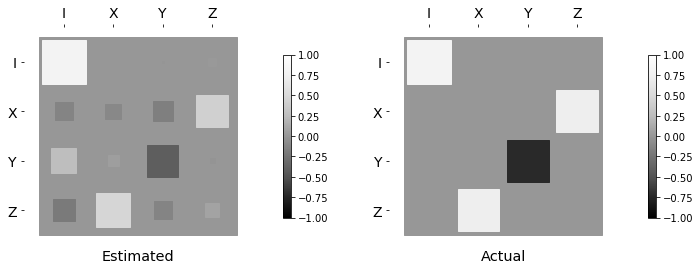

In [14]:
fig, (left, right) = plt.subplots(ncols=2, figsize=(12, 4))
plt.sca(left)
plt.xlabel('Estimated', fontsize='x-large')
qt.visualization.hinton(estimation_results['est_channel'], ax=left)
plt.sca(right)
plt.xlabel('Actual', fontsize='x-large')
qt.visualization.hinton(actual_noisy_h, ax=right)

We also obtain a wealth of other information as well, such as the covariance matrix over each parameter of the resulting channel.
This shows us which parameters we are least certain about, as well as how those parameters are correlated with each other.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text xticklabel objects>)

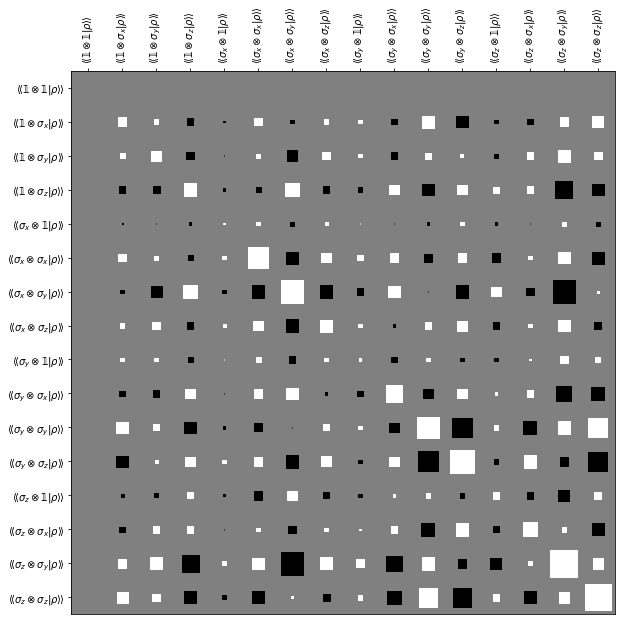

In [15]:
plt.figure(figsize=(10, 10))
estimation_results['posterior'].plot_covariance()
plt.xticks(rotation=90)

## Diagnostics ##

In [16]:
import sys
print("""
Python version:                  {}
Quantum Development Kit version: {}
""".format(sys.version, qsharp.__version__))


Python version:                  3.6.4 | packaged by conda-forge | (default, Dec 24 2017, 10:11:43) [MSC v.1900 64 bit (AMD64)]
Quantum Development Kit version: 0.2.1806.3001

